In [12]:
import tensorflow as tf

In [2]:
#sequential model
from tensorflow.keras.models import Sequential

In [3]:
#ConvNet will end with dense layer and will flatten before feeding to dense layer
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LSTM

In [4]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [5]:
#load file with pickle
import pickle
import time

In [6]:
gpu_options =tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [7]:
pickle_in = open("X_SEG.pickle", "rb")
X = pickle.load(pickle_in)
#load X

pickle_in = open("y_SEG.pickle", "rb")
y = pickle.load(pickle_in)
#load y

In [8]:
#Data needs to be normalized and since we are using image data we divide by 255 the max value, min value is 0.
X=X/255.0

In [9]:
n_test = 28350
trainX, testX = X[:n_test, :], X[n_test:, :]
trainy, testy = y[:n_test], y[n_test:]

In [23]:
dense_layers = [2]
layer_sizes = [128]
conv_layers = [2]
size = 150

In [29]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 9x9 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            padding='same'
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 7x7
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.3))
                       
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            # simple early stopping
            #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
            
            opt = Adam(lr=0.0001, decay=1e-6)
            
            model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 8705 than positives 4862
            class_weights = {0: 1.0,
                            1: 1.8} #8705/4862
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(trainX, trainy, class_weight=class_weights, batch_size=32, epochs=30, validation_split=0.3,
                       callbacks=[tensorboard])

2-conv-128-nodes-2-dense-150-dimension-1558578368
Train on 19845 samples, validate on 8505 samples
Epoch 1/30
19845/19845 [==============================] - 170s 9ms/step - loss: 0.6465 - acc: 0.6866 - val_loss: 0.6307 - val_acc: 0.6963 ETA: 10s - loss: 0.6470 - ETA: 7s - loss: 0.6470 - acc:  - ETA: 6s
Epoch 2/30
19845/19845 [==============================] - 162s 8ms/step - loss: 0.6327 - acc: 0.6967 - val_loss: 0.6275 - val_acc: 0.6994
Epoch 3/30
19845/19845 [==============================] - 152s 8ms/step - loss: 0.6285 - acc: 0.6975 - val_loss: 0.6276 - val_acc: 0.6859
Epoch 4/30
19845/19845 [==============================] - 172s 9ms/step - loss: 0.6217 - acc: 0.6985 - val_loss: 0.6287 - val_acc: 0.6384
Epoch 5/30
19845/19845 [==============================] - 154s 8ms/step - loss: 0.6170 - acc: 0.6902 - val_loss: 0.6410 - val_acc: 0.7126
Epoch 6/30
19845/19845 [==============================] - 152s 8ms/step - loss: 0.6082 - acc: 0.6986 - val_loss: 0.6314 - val_acc: 0.6834
Epoch 

In [30]:
# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

In [31]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes, average='weighted')
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(testy, yhat_probs, average='weighted')
print('ROC AUC: %f' % auc)

Accuracy: 0.678002
Precision: 0.649142
Recall: 0.678002
F1 score: 0.658541
ROC AUC: 0.630220


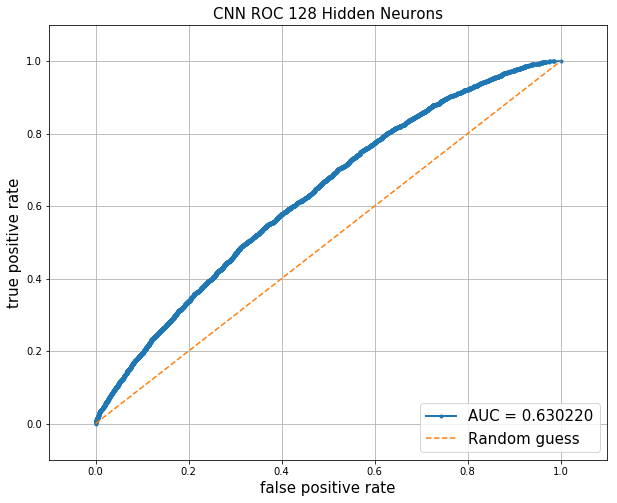

In [34]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, yhat_probs)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', linewidth=2, label='AUC = 0.630220')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.title('CNN ROC 128 Hidden Neurons', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=10,8
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()

In [34]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes, average='weighted')
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(testy, yhat_probs, average='weighted')
print('ROC AUC: %f' % auc)

Accuracy: 0.755313
Precision: 0.721724
Recall: 0.755313
F1 score: 0.736888
ROC AUC: 0.794973


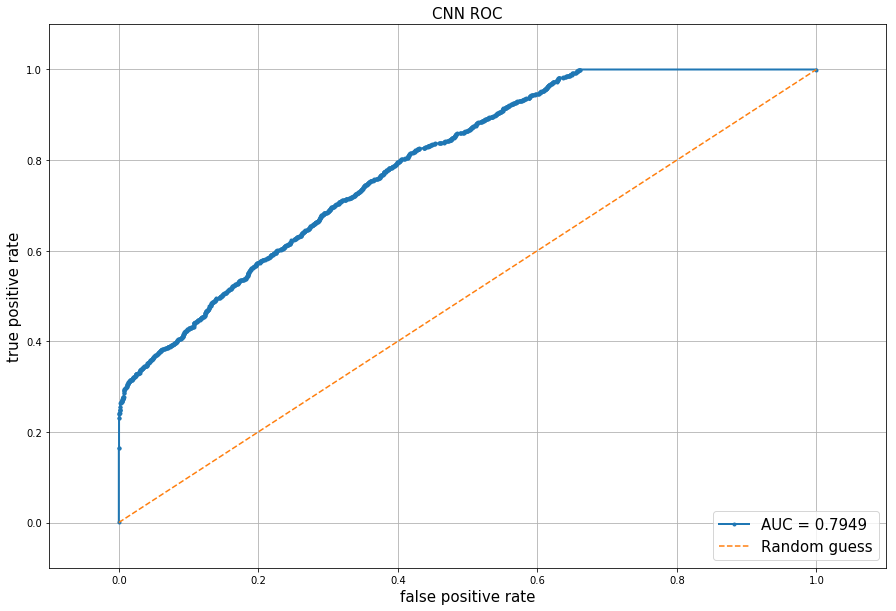

In [59]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, yhat_probs)
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', linewidth=2, label='AUC = 0.7949')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.title('CNN ROC', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=10,8
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy, yhat_classes)
print(cm)

[[3031  315]
 [ 871  630]]


In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

f1=0.737 auc=0.795 ap=0.685


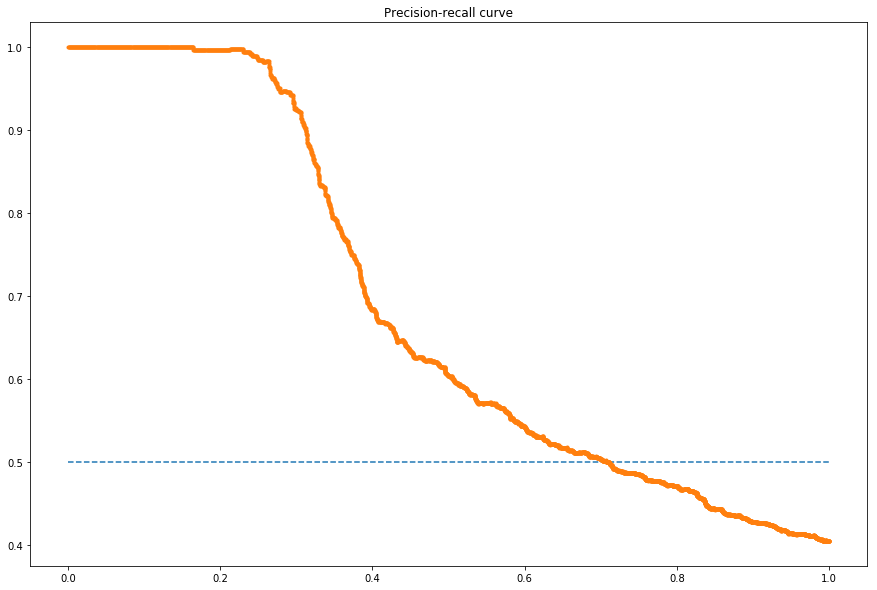

In [37]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, yhat_probs)
# calculate F1 score
f1 = f1_score(testy, yhat_classes, average='weighted')
# calculate precision-recall AUC
#auc = auc(recall, precision, average='weighted')
auc=roc_auc_score(testy, yhat_probs, average='weighted')
# calculate average precision score
ap = average_precision_score(testy, yhat_probs, average='weighted')
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title('Precision-recall curve')
# show the plot
plt.show()

In [17]:
dense_layers = [1,2,3]
layer_sizes = [64]
conv_layers = [1,2,3]
size = 100

In [12]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            padding='same'
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.3))
            
            #Conv layer, activation and pooling layers 2
            #for l in range(conv_layer-1):
             #   model.add(Conv2D(layer_size, (7,7)))
             #   model.add(Activation("relu"))
             #   model.add(MaxPooling2D(pool_size=(5,5)))
             #   model.add(Dropout(0.1))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='Adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 8705 than positives 4862
            class_weights = {0: 1.0,
                            1: 1.8} #8705/4862
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(trainX, trainy, class_weight=class_weights, batch_size=20, epochs=10, validation_split=0.3, callbacks=[tensorboard])

1-conv-32-nodes-2-dense-100-dimension-1555551030
Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 23s 1ms/step - loss: 0.5539 - acc: 0.6586 - val_loss: 0.5220 - val_acc: 0.7077
Epoch 2/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.5213 - acc: 0.7060 - val_loss: 0.5168 - val_acc: 0.7175
Epoch 3/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.5162 - acc: 0.7167 - val_loss: 0.5158 - val_acc: 0.7299
Epoch 4/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.5119 - acc: 0.7259 - val_loss: 0.5070 - val_acc: 0.7259
Epoch 5/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.5053 - acc: 0.7317 - val_loss: 0.5074 - val_acc: 0.7416
Epoch 6/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0.4986 - acc: 0.7392 - val_loss: 0.5028 - val_acc: 0.7363
Epoch 7/10
17500/17500 [==============================] - 21s 1ms/step - loss: 0

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 64)        15616     
_________________________________________________________________
activation (Activation)      (None, 92, 92, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                692288    
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
__________

In [19]:
# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [62]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.714137
Precision: 0.603194
Recall: 0.714137
F1 score: 0.650706


In [63]:
# ROC AUC
auc = roc_auc_score(testy, yhat_probs, average='weighted')
print('ROC AUC: %f' % auc)

ROC AUC: 0.619653


No handles with labels found to put in legend.


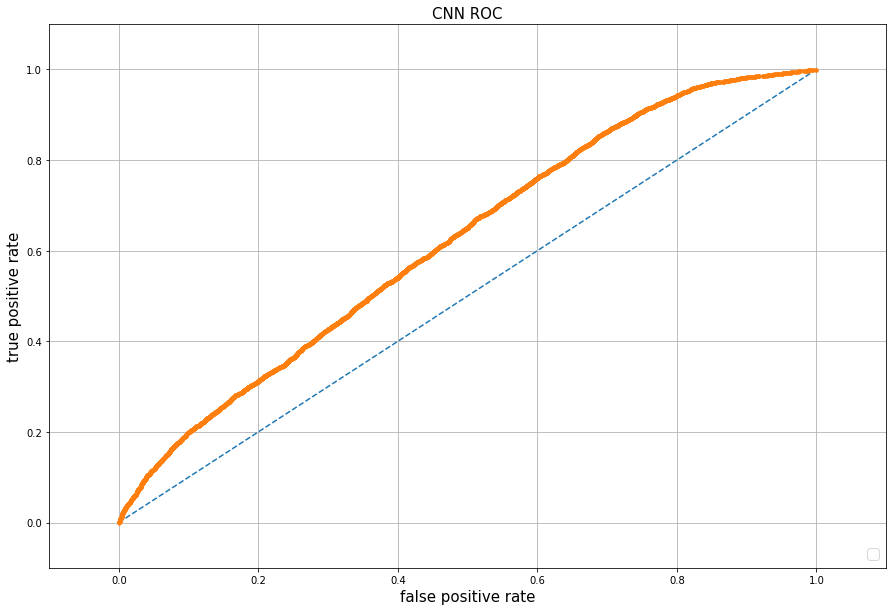

In [120]:
import matplotlib.pyplot as plt

# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, yhat_probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', linewidth=2)
plt.title('CNN ROC', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.rcParams["figure.figsize"]=15,10
#plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate', fontsize=15)
plt.ylabel('true positive rate', fontsize=15)
# show the plot
plt.show()

In [117]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

f1=0.651 auc=0.620 ap=0.378


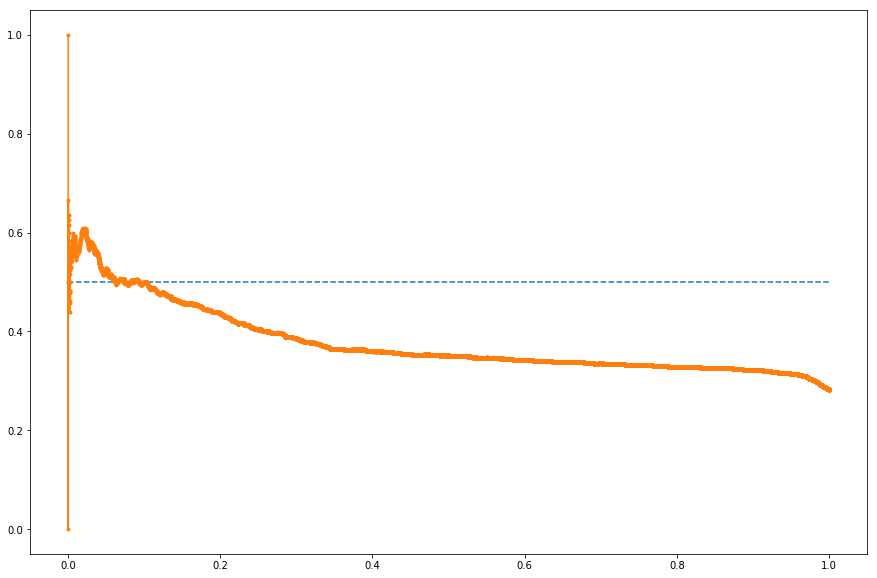

In [118]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, yhat_probs)
# calculate F1 score
f1 = f1_score(testy, yhat_classes, average='weighted')
# calculate precision-recall AUC
#auc = auc(recall, precision, average='weighted')
auc=roc_auc_score(testy, yhat_probs, average='weighted')
# calculate average precision score
ap = average_precision_score(testy, yhat_probs, average='weighted')
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

In [19]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (11,11), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(9,9)))
            model.add(Dropout(0.4))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (11,11)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(9,9)))
                model.add(Dropout(0.4))
                
           # for l in range(conv_layer-2):
           #     model.add(Conv2D(layer_size, (5,5)))
           #     model.add(Activation("relu"))
           #     model.add(MaxPooling2D(pool_size=(5,5)))
           #     model.add(Dropout(0.4))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 8705 than positives 4862
            class_weights = {0: 1.,
                             1: 1} #8705/4862
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=20, epochs=1, validation_split=0.3, callbacks=[tensorboard])

3-conv-64-nodes-1-dense-100-dimension-1553674093


ValueError: Negative dimension size caused by subtracting 11 from 10 for 'conv2d_23/Conv2D' (op: 'Conv2D') with input shapes: [?,10,10,64], [11,11,64,64].

In [13]:
model.save('ALTS-NHS-2x32x1-CNN.model')

In [15]:
from quiver_engine import server
server.launch(model)
#quiver_engine.server.launch(model, classes=['Neg','Pos'], input_folder= r"D:\suleiman\Documents\ALTS\400x400\)

Starting webserver from: C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\quiver_engine


::1 - - [2018-12-18 14:00:01] "GET / HTTP/1.1" 304 241 0.014960
::1 - - [2018-12-18 14:00:01] "GET /app.14b8092d6ea379715007.js HTTP/1.1" 304 243 0.022938
::1 - - [2018-12-18 14:00:01] "GET /app.c1d3d21cfba8c1aabed6806773c8f0ba.css HTTP/1.1" 304 242 0.005984
::1 - - [2018-12-18 14:00:01] "GET /vendor.280c5ce1d78077ee8d66.js HTTP/1.1" 304 243 0.013960
::1 - - [2018-12-18 14:00:02] "GET /model HTTP/1.1" 200 3657 0.004985
::1 - - [2018-12-18 14:00:02] "GET /inputs HTTP/1.1" 200 163 0.000992
::1 - - [2018-12-18 14:00:02] "GET /input-file/CIN.jpg HTTP/1.1" 200 41371 0.003017
::1 - - [2018-12-18 14:00:02] "GET /input-file/CIN2.jpg HTTP/1.1" 200 22570 0.002992
Traceback (most recent call last):
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\gevent\_ffi\loop.py", line 230, in python_check_callback
    def python_check_callback(self, watcher_ptr): # pylint:disable=unused-argument
KeyboardInterrupt
2018-12-19T01:24:01Z


KeyboardInterrupt: 

In [14]:
dense_layers = [0]
layer_sizes = [32]
conv_layers = [1]

In [16]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
             NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.20))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (9,9)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(7,7)))
                model.add(Dropout(0.10))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 6873 than positives 3076
            class_weights = {0: 1.,
                             1: 1.8} #6873/3076
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=10, epochs=3, validation_split=0.3, callbacks=[tensorboard])

1-conv-32-nodes-0-dense-1544767125
Train on 9496 samples, validate on 4071 samples
Epoch 1/3
9496/9496 [==============================] - 129s 14ms/step - loss: 0.6457 - acc: 0.6868 - val_loss: 0.6249 - val_acc: 0.7136
Epoch 2/3
9496/9496 [==============================] - 190s 20ms/step - loss: 0.6490 - acc: 0.7010 - val_loss: 0.6231 - val_acc: 0.6949
Epoch 3/3
9496/9496 [==============================] - 191s 20ms/step - loss: 0.6267 - acc: 0.6910 - val_loss: 0.6235 - val_acc: 0.7015


In [17]:
dense_layers = [1]
layer_sizes = [32]
conv_layers = [2]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.20))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (9,9)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(7,7)))
                model.add(Dropout(0.10))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 6873 than positives 3076
            class_weights = {0: 1.,
                             1: 1.8} #6873/3076
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=10, epochs=3, validation_split=0.3, callbacks=[tensorboard])

2-conv-32-nodes-1-dense-1544768681
Train on 9496 samples, validate on 4071 samples
Epoch 1/3
9496/9496 [==============================] - 144s 15ms/step - loss: 0.6753 - acc: 0.7027 - val_loss: 0.6750 - val_acc: 0.7136
Epoch 2/3
9496/9496 [==============================] - 189s 20ms/step - loss: 0.6742 - acc: 0.7161 - val_loss: 0.6749 - val_acc: 0.7136
Epoch 3/3
9496/9496 [==============================] - 173s 18ms/step - loss: 0.6739 - acc: 0.7161 - val_loss: 0.6749 - val_acc: 0.7136


In [20]:
dense_layers = [2]
layer_sizes = [64]
conv_layers = [2]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (9,9), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(7,7)))
            model.add(Dropout(0.25))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (9,9)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(7,7)))
                model.add(Dropout(0.1))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 6873 than positives 3076
            class_weights = {0: 1.,
                             1: 1.8} #6873/3076
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=30, epochs=3, validation_split=0.3, callbacks=[tensorboard])

2-conv-64-nodes-2-dense-1544773731
Train on 9496 samples, validate on 4071 samples
Epoch 1/3
9496/9496 [==============================] - 167s 18ms/step - loss: 0.6765 - acc: 0.6986 - val_loss: 0.6788 - val_acc: 0.7136
Epoch 2/3
9496/9496 [==============================] - 215s 23ms/step - loss: 0.6780 - acc: 0.7161 - val_loss: 0.6789 - val_acc: 0.7136
Epoch 3/3
9496/9496 [==============================] - 192s 20ms/step - loss: 0.6780 - acc: 0.7144 - val_loss: 0.6787 - val_acc: 0.7136


In [9]:
dense_layers = [4]
layer_sizes = [32, 64]
conv_layers = [1,2,3]

In [10]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (3,3), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(0.25))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.1))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 6873 than positives 3076
            class_weights = {0: 1.,
                             1: 2.23} #6873/3076
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=10, epochs=3, validation_split=0.3, callbacks=[tensorboard])

1-conv-32-nodes-4-dense-1543288834
Train on 6964 samples, validate on 2985 samples
Epoch 1/3
6964/6964 [==============================] - 17s 3ms/step - loss: 0.6985 - acc: 0.6216 - val_loss: 0.6924 - val_acc: 0.6901986 - acc: - ETA: 0s - loss: 0.6987 - a
Epoch 2/3
6964/6964 [==============================] - 16s 2ms/step - loss: 0.6924 - acc: 0.6328 - val_loss: 0.6953 - val_acc: 0.3327A: 9s - loss: 0.6925 - ac - ETA: 8s 
Epoch 3/3
6964/6964 [==============================] - 16s 2ms/step - loss: 0.6924 - acc: 0.6025 - val_loss: 0.6916 - val_acc: 0.6496
2-conv-32-nodes-4-dense-1543288888
Train on 6964 samples, validate on 2985 samples
Epoch 1/3
6964/6964 [==============================] - 16s 2ms/step - loss: 0.6936 - acc: 0.6624 - val_loss: 0.6925 - val_acc: 0.6901
Epoch 2/3
6964/6964 [==============================] - 14s 2ms/step - loss: 0.6926 - acc: 0.6854 - val_loss: 0.6924 - val_acc: 0.6901
Epoch 3/3
6964/6964 [==============================] - 15s 2ms/step - loss: 0.6923 - acc:

In [9]:
dense_layers = [0]
layer_sizes = [128]
conv_layers = [1,2,3]

In [10]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (3,3), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(0.25))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.1))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 6873 than positives 3076
            class_weights = {0: 1.,
                             1: 2.23} #6873/3076
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=10, epochs=3, validation_split=0.3, callbacks=[tensorboard])

1-conv-128-nodes-0-dense-1542782659
Train on 6964 samples, validate on 2985 samples
Epoch 1/3
6964/6964 [==============================] - 52s 7ms/step - loss: 8.3349 - acc: 0.3087 - val_loss: 8.3100 - val_acc: 0.3099o - ETA: 19s - loss: 8.30 - ETA: 19s - loss - ETA:  - ETA: 10s - loss: 8.403 - ETA: 9s - loss: 8.402 - E - ETA: 1s - loss: 8
Epoch 2/3
6964/6964 [==============================] - 52s 8ms/step - loss: 8.3419 - acc: 0.3089 - val_loss: 8.3100 - val_acc: 0.3099- ETA: 10s  - ETA: 8s - loss: 8.3837 - acc: 0.3 - ETA: 8s - - ETA: 6s - loss: 8.3850 - ac - ETA: 5s - - ETA: 1s - loss: 8.3242 -  - ETA: 1s - loss: 
Epoch 3/3
6964/6964 [==============================] - 51s 7ms/step - loss: 8.3745 - acc: 0.3089 - val_loss: 8.3100 - val_acc: 0.3099
2-conv-128-nodes-0-dense-1542782815
Train on 6964 samples, validate on 2985 samples
Epoch 1/3
6964/6964 [==============================] - 65s 9ms/step - loss: 0.7007 - acc: 0.6887 - val_loss: 0.6924 - val_acc: 0.6901
Epoch 2/3
6964/6964 [===

In [13]:
dense_layers = [1]
layer_sizes = [128]
conv_layers = [1,2,3]

In [14]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
             NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (3,3), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(0.25))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.1))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 6873 than positives 3076
            class_weights = {0: 1.,
                             1: 2.23} #6873/3076
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=10, epochs=3, validation_split=0.3, callbacks=[tensorboard])

1-conv-128-nodes-1-dense-1542784371
Train on 6964 samples, validate on 2985 samples


ResourceExhaustedError: OOM when allocating tensor with shape[700928,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_10/kernel/Initializer/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, _class=["loc:@dense_10/kernel/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_10/kernel/Initializer/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_10/kernel/Initializer/random_uniform/RandomUniform', defined at:
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-88f13bcd4031>", line 30, in <module>
    model.add(Dense(layer_size))
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 426, in _method_wrapper
    method(self, *args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 175, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 759, in __call__
    self.build(input_shapes)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\layers\core.py", line 921, in build
    trainable=True)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 586, in add_weight
    aggregation=aggregation)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 591, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1986, in make_variable
    aggregation=aggregation)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 145, in __call__
    return cls._variable_call(*args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 141, in _variable_call
    aggregation=aggregation)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 120, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2434, in default_variable_creator
    import_scope=import_scope)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 147, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 297, in __init__
    constraint=constraint)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 411, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1970, in <lambda>
    shape, dtype=dtype, partition_info=partition_info)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\init_ops.py", line 483, in __call__
    shape, -limit, limit, dtype, seed=self.seed)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gen_random_ops.py", line 772, in random_uniform
    name=name)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[700928,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node dense_10/kernel/Initializer/random_uniform/RandomUniform}} = RandomUniform[T=DT_INT32, _class=["loc:@dense_10/kernel/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_10/kernel/Initializer/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [15]:
dense_layers = [2]
layer_sizes = [128]
conv_layers = [1,2,3]

In [16]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (3,3), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(0.25))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.1))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 6873 than positives 3076
            class_weights = {0: 1.,
                             1: 2.23} #6873/3076
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=10, epochs=3, validation_split=0.3, callbacks=[tensorboard])

1-conv-128-nodes-2-dense-1542784406
Train on 6964 samples, validate on 2985 samples


ResourceExhaustedError: OOM when allocating tensor of shape [700928,128] and type float
	 [[{{node training_9/Adam/zeros_10}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [700928,128] values: [0 0 0...]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'training_9/Adam/zeros_10', defined at:
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-88f13bcd4031>", line 51, in <module>
    model.fit(X, y, class_weight=class_weights, batch_size=10, epochs=3, validation_split=0.3, callbacks=[tensorboard])
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1605, in fit
    validation_steps=validation_steps)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training_arrays.py", line 86, in fit_loop
    model._make_train_function()
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py", line 715, in _make_train_function
    params=self._collected_trainable_weights, loss=self.total_loss)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\optimizers.py", line 472, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\optimizers.py", line 472, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\backend.py", line 1025, in zeros
    v = array_ops.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1561, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3359, in fill
    "Fill", dims=dims, value=value, name=name)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3272, in create_op
    op_def=op_def)
  File "C:\Users\suleiman\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [700928,128] and type float
	 [[{{node training_9/Adam/zeros_10}} = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [700928,128] values: [0 0 0...]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
dense_layers = [3]
layer_sizes = [128]
conv_layers = [1,2,3]

In [ ]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}-dimension-{}".format(conv_layer, layer_size, dense_layer, size, int(time.time()))
            
            print(NAME)
            #build our model with sequential
            model = Sequential()
            
            # start with Conv layer 1 and pass layer sizes, 3x3 window, input data features
            model.add(Conv2D(layer_size, (3,3), input_shape = X.shape[1:]))
            
            #after convolution pass activation layer 1 with 'rectified linear'
            model.add(Activation("relu"))
            
            #pass max pooling layer 1 with 2x2
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(0.25))
            
            #Conv layer, activation and pooling layers 2
            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.1))
            
            #need to flatten before passing to dense layer
            model.add(Flatten()) 
            for l in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation("relu"))
            
            #add finally an output dense layer of size 1
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            tensorboard = TensorBoard(log_dir= 'logs/{}'.format(NAME))
            
            #compile our model and measure the performance of classification 
            #Adam is a popular algorithm in the field of deep learning because it achieves good results fast
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])
            
            #unbalanced class with more negatives 6873 than positives 3076
            class_weights = {0: 1.,
                             1: 2.23} #6873/3076
            
            #fit model set how many to pass as a time in batch size, with 30% for validation
            model.fit(X, y, class_weight=class_weights, batch_size=10, epochs=3, validation_split=0.3, callbacks=[tensorboard])

In [37]:
model.save('ALTS-1x64x1-CNN.model')

In [22]:
val_loss, val_acc = model.evaluate(X, y)
print(val_loss, val_acc)

9947/9947 [==============================] - 164s 16ms/step
0.6777853000472033 0.6909620991013955
